In [1]:
import tensorflow as tf

from tensorflow.keras.applications import vgg19, resnet50
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPool2D, Input, Lambda, Dense, GlobalAveragePooling2D

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
from texture.datasets import FMDDataset, DatasetSequence

fmd_dataset = FMDDataset('/home/ross/Dropbox/benchmark/FlickrMaterials/', input_size=300)
fmd_dataset.load_or_generate_data()

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


/home/ross/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
vgg = vgg19.VGG19(include_top=False)

res = resnet50.ResNet50(include_top=False)

In [10]:
def avg_layer_model(model):
    outputs = []
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            response = GlobalAveragePooling2D(name=layer.name+'_avg')(layer.output)
            outputs.append(response)
    
    return KerasModel(inputs=model.inputs, outputs=outputs)
            
            
avg_layer_model(vgg).summary(line_length=110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                (None, None, None, 3)   0                                                 
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)               (None, None, None, 64)  1792         input_1[0][0]                        
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)               (None, None, None, 64)  36928        block1_conv1[0][0]                   
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, None, None, 64)  0            block1_conv2[0][0]                   
_

In [44]:
vgg_top = vgg19.VGG19(include_top=True)

In [52]:
from tensorflow.keras import backend as K

import numpy as np
from skimage.transform import resize

import matplotlib.pyplot as plt

In [57]:
vgg_top.layers[-1].activation = lambda x: x

loss = K.mean(vgg_top.layers[-1].output[:,22])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, vgg_top.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-4)

# this function returns the loss and grads given the input picture
iterate = K.function([vgg_top.input], [loss, grads])


/home/ross/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ross/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


current_loss:  0.00022258954
current_loss:  0.00026054998
current_loss:  0.00031822448
current_loss:  0.00041334436
current_loss:  0.00055961264
current_loss:  0.0007595911
current_loss:  0.000998583
current_loss:  0.0012826954
current_loss:  0.0016379923
current_loss:  0.002104572
current_loss:  0.0027059165
current_loss:  0.0034339842
current_loss:  0.004366759
current_loss:  0.0055909064
current_loss:  0.007046845
current_loss:  0.0088674985
current_loss:  0.010134038
current_loss:  0.0110466955
current_loss:  0.011455185
current_loss:  0.017381163
current_loss:  0.019952698
current_loss:  0.025744058
current_loss:  0.034015674
current_loss:  0.03798662
current_loss:  0.04753007
current_loss:  0.1272596
current_loss:  0.12707348
current_loss:  0.15302682
current_loss:  0.2819946
current_loss:  0.2841246
current_loss:  0.5069084
current_loss:  0.52097696
current_loss:  0.6291135
current_loss:  0.8019207
current_loss:  0.88743556
current_loss:  0.9371469
current_loss:  0.9641956
curre

current_loss:  0.9982267
current_loss:  0.99823076
current_loss:  0.9982346
current_loss:  0.9982389
current_loss:  0.99824286
current_loss:  0.998247
current_loss:  0.9982509
current_loss:  0.99825484
current_loss:  0.9982591
current_loss:  0.99826294
current_loss:  0.9982668
current_loss:  0.998271
current_loss:  0.9982748
current_loss:  0.99827886
current_loss:  0.9982827
current_loss:  0.99828655
current_loss:  0.99829036
current_loss:  0.99829406
current_loss:  0.998298
current_loss:  0.998302
current_loss:  0.9983057
current_loss:  0.99830925
current_loss:  0.99831307
current_loss:  0.9983169
current_loss:  0.9983205
current_loss:  0.9983242
current_loss:  0.9983277
current_loss:  0.99833137
current_loss:  0.99833494
current_loss:  0.99833846
current_loss:  0.99834204
current_loss:  0.99834573
current_loss:  0.9983494
current_loss:  0.9983529
current_loss:  0.99835616
current_loss:  0.99835974
current_loss:  0.9983631
current_loss:  0.99836653
current_loss:  0.99837
current_loss:

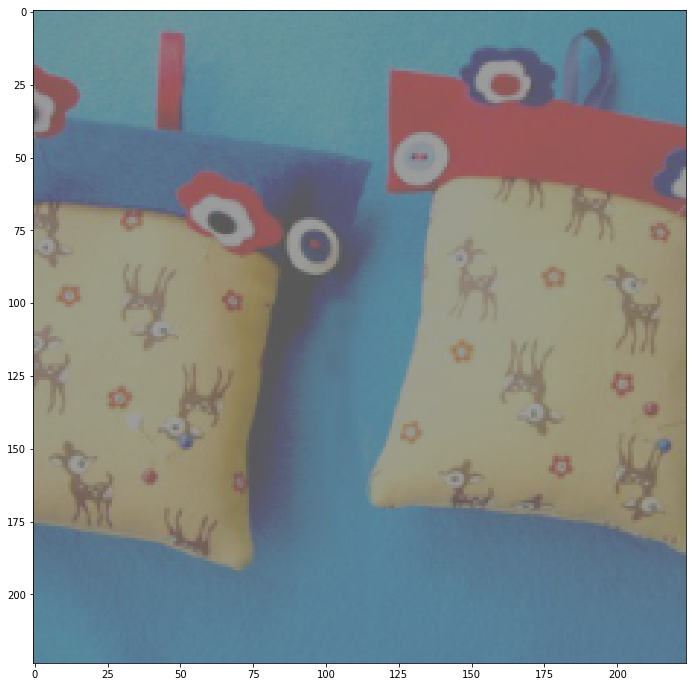

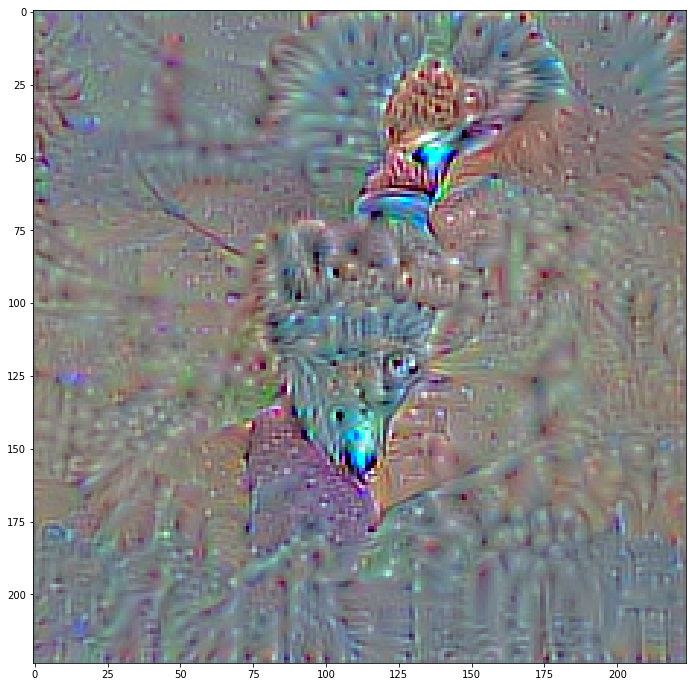

In [63]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


input_img_data = np.expand_dims(resize(fmd_dataset.X_train[100], (224,224,3)), 0)
input_img_data -= input_img_data.min()
input_img_data /= input_img_data.max()
input_img_data *= 255

step = 0.1

f, ax = plt.subplots(figsize=(12,12))
ax.imshow(deprocess_image(input_img_data[0]))

for i in range(500):
    loss_val, grads_val = iterate([input_img_data])
    input_img_data += grads_val * step
    
    print('current_loss: ', loss_val)
    
f, ax = plt.subplots(figsize=(12,12))
ax.imshow(deprocess_image(input_img_data[0]))

In [34]:
vgg_top.output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>

In [36]:
vgg_top.input_shape

(None, 224, 224, 3)

In [37]:
(1,) + (2,3)

(1, 2, 3)

In [48]:
fmd_dataset.X_train[0]

array([[[0.92219451, 0.80047216, 0.62015686],
        [0.92431373, 0.79881412, 0.62038745],
        [0.92658824, 0.79717647, 0.62070588],
        ...,
        [0.96424314, 0.77921569, 0.71756863],
        [0.96383843, 0.77451451, 0.71482353],
        [0.96478275, 0.77262588, 0.70855059]],

       [[0.93239686, 0.80689725, 0.63176471],
        [0.93530824, 0.80589647, 0.63272   ],
        [0.93893333, 0.80721569, 0.63519216],
        ...,
        [0.97142745, 0.77921569, 0.7348549 ],
        [0.9721851 , 0.77551529, 0.72980392],
        [0.97019608, 0.77145098, 0.72643137]],

       [[0.94666667, 0.8172549 , 0.65411765],
        [0.94666667, 0.8172549 , 0.65411765],
        [0.95215686, 0.8172549 , 0.65686275],
        ...,
        [0.98435294, 0.78305882, 0.76670588],
        [0.98330196, 0.77419608, 0.7588    ],
        [0.98212549, 0.77153725, 0.75663529]],

       ...,

       [[0.91422745, 0.88363922, 0.79265882],
        [0.85630588, 0.82621176, 0.73193725],
        [0.7832549 , 0

In [61]:
vgg_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________